In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
###### %autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import xarray as xr
import pickle

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from statisticalDistributions import *
from plot1DInvLog import *
from importingData import *
from savingResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['thermoConstants', 'setEnv', 'importingData', 'statisticalDistributions', 'plot1DInvLog', 'dataFormat', 'savingResults', 'scalingApproximations', 'slicingAndSubsetting']


In [15]:
# Simulation root name
case = 'RCE'
Nxyz = '256x256x64'
Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
simroot = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_%s"%Nxyz
SSTs = (300,304)
states = 'disorganized','organized'
state_label = {'organized':'','disorganized':'-radhomo'}
colors = dict(zip(states,('#ff7f0e','#1f77b4')))
colors_SST = dict(zip(SSTs,('k','r')))

In [4]:
archivedir = getArchivedir(machine='coriknl')
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures')

In [5]:
perc_ILQ_pr = {}
cdf_ILQ_pr = {}
ranks_ILQ_pr = {}
ds_dict = {}
spatvar = {}
for SST in SSTs:
    perc_ILQ_pr[SST] = {}
    ranks_ILQ_pr[SST] = {}
    cdf_ILQ_pr[SST] = {}
    ds_dict[SST] = {}
    spatvar[SST] = {}
    for state in states:
        print('SST =',SST, ', state =',state)
        expname = "TKE-SST%d%s-r1"%(SST,state_label[state])
        resultsubdir = os.path.join(resultdir,simroot,expname,'xy_stats_over_time')
        perc_ILQ_pr[SST][state] = pickle.load(open(os.path.join(resultsubdir,'percentiles_ILQ_pr.pickle'),'rb'))
        ranks_ILQ_pr[SST][state] = pickle.load(open(os.path.join(resultsubdir,'ranks_ILQ_pr.pickle'),'rb'))
        cdf_ILQ_pr[SST][state] = pickle.load(open(os.path.join(resultsubdir,'cdf_ILQ_pr.pickle'),'rb'))
        spatvar[SST][state] = pickle.load(open(os.path.join(resultsubdir,'spatial_variances.pickle'),'rb'))
        simname = "%s_%s"%(simroot,expname)
        simdir = os.path.join(archivedir,simname,'OUT_STAT')
        filename = "%s.nc"%(simname)
        ds_dict[SST][state] = xr.open_dataset(os.path.join(simdir,filename))


SST = 300 , state = disorganized
SST = 300 , state = organized
SST = 304 , state = disorganized
SST = 304 , state = organized


In [6]:
time_labels = np.array(list(perc_ILQ_pr[SSTs[0]][states[0]].keys()))
Ts = np.arange(240,2400,240)
dt = 10 # days
sT90 = slice(int(Ts[-1]-dt/2*24),int(Ts[-1]+dt/2*24))
t90 = time_labels[-1]

In [7]:
Qmax = 99.99
iQmax = indexOfRank(Qmax,ranks_ILQ_pr[SSTs[0]][states[0]][time_labels[0]])
sQ = slice(0,iQmax)
ranks = ranks_ILQ_pr[SSTs[0]][states[0]][time_labels[0]][sQ]

# Compare distributions

In [8]:
figsubdir_distrib = os.path.join(figuredir,'distributions')
if not os.path.exists(figsubdir_distrib): os.makedirs(figsubdir_distrib)

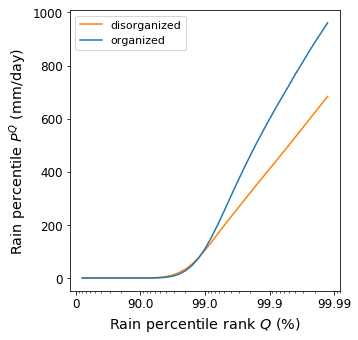

In [21]:
fig,ax = plt.subplots(ncols=1,figsize=(5,5))

SST = 300

for state in states:
    
    # PDF
    subplotRanksILog(ax,ranks_ILQ_pr[SST][state][t90][sQ],
                 [perc_ILQ_pr[SST][state][t90][sQ]],ltype=['-'],col=[colors[state]],
                 labels=[state],transformX=(state==states[-1]))

# ax[0].set_yscale('log')
ax.set_ylabel(r'Rain percentile $P^Q$ (mm/day)')
ax.set_xlabel(r'Rain percentile rank $Q$ (%)')

ax.legend(fontsize=11)

plt.savefig(os.path.join(figsubdir_distrib,'pdf_pr_%s.pdf'%('_'.join(states))),bbox_layout='tight')
plt.show()

/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


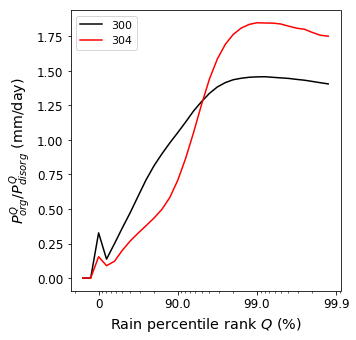

In [20]:
fig,ax = plt.subplots(ncols=1,figsize=(5,5))

for SST in SSTs:
    # PDF
    subplotRanksILog(ax,ranks_ILQ_pr[SST][states[0]][t90][sQ],
                 [perc_ILQ_pr[SST][states[1]][t90][sQ]/perc_ILQ_pr[SST][states[0]][t90][sQ]],ltype=['-'],col=[colors_SST[SST]],
                 labels=[SST],transformX=(SST==SSTs[-1]))

# ax[0].set_yscale('log')
ax.set_ylabel(r'$P_{org}^Q/P_{disorg}^Q$ (mm/day)')
ax.set_xlabel(r'Rain percentile rank $Q$ (%)')

ax.legend(fontsize=11)

plt.savefig(os.path.join(figsubdir_distrib,'pdf_pr_org_div_disorg_%s.pdf'%('%d_%d'%(SSTs))),bbox_layout='tight')
plt.show()

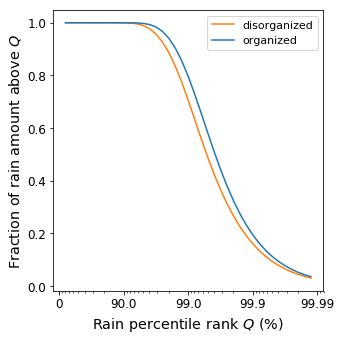

In [33]:
fig,ax = plt.subplots(ncols=1,figsize=(5,5))

SST = 300

for state in states:
    
    # PDF
    subplotRanksILog(ax,ranks_ILQ_pr[SST][state][t90][sQ],
                 [cdf_ILQ_pr[SST][state][t90][sQ]],ltype=['-'],col=[colors[state]],
                 labels=[state],transformX=(state==states[-1]))

# ax[0].set_yscale('log')
ax.set_ylabel(r'Fraction of rain amount above $Q$')
ax.set_xlabel(r'Rain percentile rank $Q$ (%)')

ax.legend(fontsize=11)

plt.savefig(os.path.join(figsubdir_distrib,'cdfinv_pr_amounts_%s.pdf'%('_'.join(states))),bbox_layout='tight')
plt.show()

# Time series

In [24]:
figsubdir_spatstats= os.path.join(figuredir,'xy_stats')
if not os.path.exists(figsubdir_spatstats): os.makedirs(figsubdir_spatstats)

## Spatial variance of PW

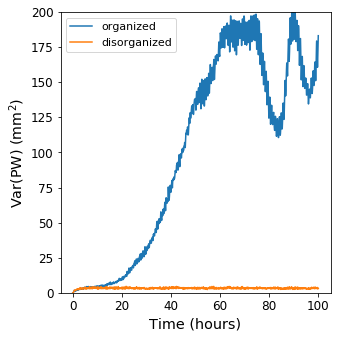

In [45]:
fig,ax = plt.subplots(ncols=1,figsize=(5,5))

SST = 300
varid = 'PW'

for state in states[::-1]:
    
    spatvar[SST][state][varid].plot(ax=ax,label=state)

# ax[0].set_yscale('log')
ax.set_ylabel(r'Var(PW) (mm$^2$)')
ax.set_xlabel(r'Time (hours)')
ax.set_ylim((0,200))

ax.legend(fontsize=11)

# plt.savefig(os.path.join(figsubdir_distrib,'cdfinv_pr_amounts_%s.pdf'%('_'.join(states))),bbox_layout='tight')
plt.show()

## OLR

In [ ]:
figsubdir_spatstats= os.path.join(figuredir,'xy_stats')
if not os.path.exists(figsubdir_spatstats): os.makedirs(figsubdir_spatstats)

NameError: name 'figsubdir_spatstats' is not defined

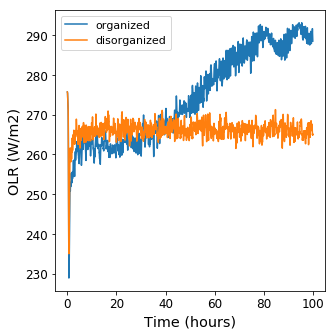

In [22]:
fig,ax = plt.subplots(ncols=1,figsize=(5,5))

SST = 300
varid = 'PW'

for state in states[::-1]:
    
    ds_dict[SST][state].LWNT.plot(ax=ax,label=state)

# ax[0].set_yscale('log')
ax.set_ylabel(r'OLR (W/m2)')
ax.set_xlabel(r'Time (hours)')
# ax.set_ylim((0,200))

ax.legend(fontsize=11)

plt.savefig(os.path.join(figsubdir_spatstats,'cdfinv_pr_amounts_%s.pdf'%('_'.join(states))),bbox_layout='tight')
plt.show()

# Vertical profiles

In [9]:
figsubdir_profiles = os.path.join(figuredir,'profiles')
if not os.path.exists(figsubdir_profiles): os.makedirs(figsubdir_profiles)

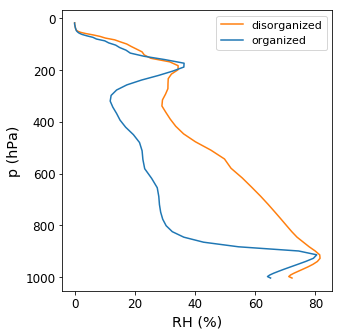

In [29]:
SST = 300

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

for state in states:
    ax.plot(ds_dict[SST][state]['RELH'].data[sT90].mean(axis=0),ds_dict[SST][state].p,label=state,c=colors[state])
ax.legend(fontsize=11)
ax.invert_yaxis()
ax.set_ylabel('p (hPa)')
ax.set_xlabel('RH (%)')

plt.savefig(os.path.join(figsubdir_profiles,'relh_%s.pdf'%('_'.join(states))),bbox_layout='tight')
plt.show()

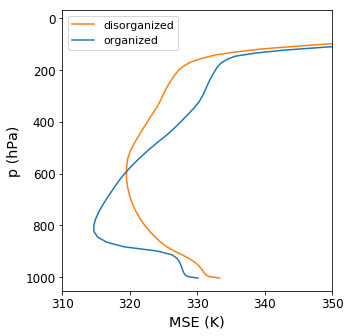

In [28]:
SST = 300

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

for state in states:
    ax.plot(ds_dict[SST][state]['MSE'].data[sT90].mean(axis=0),ds_dict[SST][state].p,label=state,c=colors[state])
ax.legend(fontsize=11)
ax.invert_yaxis()
ax.set_ylabel('p (hPa)')
ax.set_xlabel('MSE (K)')
ax.set_xlim((310,350))

plt.savefig(os.path.join(figsubdir_profiles,'mse_%s.pdf'%('_'.join(states))),bbox_layout='tight')
plt.show()